In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
)

# from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

# Display rows and columns 

pd.set_option('display.max_rows', 200) 
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_colwidth', 300)

# Display all outputs 
from IPython.core.interactiveshell import InteractiveShell 

InteractiveShell.ast_node_interactivity = 'last_expr'


# import jupyter_black

# jupyter_black.load()

In [2]:
# MIKES
dataset = pd.read_csv("datasets/2015.csv")

In [3]:
data = dataset.round().copy()  # MIKES Modified
# remove observations where _MICHD is missing
data = data[~data["_MICHD"].isna()]
data["_MICHD"].value_counts()

_MICHD
2.0    398881
1.0     38633
Name: count, dtype: int64

The _MICHD variable indicates if a patient has had either mycardial infarction (heart attack) or coronary heart disease. This is an engineered feature in the original dataset that was derived from features CVDINFR4 and CVDCRHD4. 
1. CVDINFR4: have you ever had a heart attack, also called a myocardial infarction (MI)? 
2. CVDCRHD4: have you ever been diagnosed with angina or coronary heart disease (CHD)?

Target classes:
- Class 1: Reported having MI or CHD (CVDINFR4=1 OR CVDCRHD4=1)
- Class 2: Did not report having MI or CHD (CVDINFR4=2 OR CVDCRHD4=2)
Blank/NA: Not asked or missing (CVDINFR4=7, 9 OR MISSING OR CVDCRHD4=7, 9, OR MISSING)

We have dropped the observations with an _MICHD value of NaN for the 2015 dataset. 

In [4]:
# recode target variable: 0 no heart disease, 1 heart disease
data["_MICHD"] = data["_MICHD"].map(lambda x: 0 if x == 2 else 1)
# drop "CVDINFR4", "CVDCRHD4", since these were used to engineer the _MICHD target
data = data.drop(["CVDINFR4", "CVDCRHD4"], axis=1)

### Balance the dataset:
- a) Remove columns with greater than 30% missingness
- b) Remove rows with missing values (any amount) where "_MICHD" = 0 (no heart disese)
- c) Downsample "_MICHD" = 0 to equal rows in "_MICHD" = 1

In [5]:
# a) Remove columns with greater than 30% missingness

# calculate the percentage of missing values in each column
missing_percentage = (data.isnull().sum() / len(data)) * 100

# create a new DataFrame to display the results
data_missing = pd.DataFrame(
    {
        "Column": missing_percentage.index,
        "missing_percentage": missing_percentage.values,
    }
)

# get columns with greater than 30% missingness
data_missing = data_missing[data_missing["missing_percentage"] > 30].sort_values(
    by="missing_percentage", ascending=False
)

data_missing.shape

(180, 2)

In [6]:
# remove columns with greater than 30% missingness
selected_columns = data.columns.difference(
    data_missing["Column"].values.tolist()
)
data_removed_30_threshold = (data[selected_columns]).copy()

data_removed_30_threshold.shape

(437514, 148)

In [7]:
# b) Remove rows with missing values (any amount) where "_MICHD" = 0 (no heart disese)

# Create column with calculaated number of NaN in the row
data_removed_30_threshold['number_rows_NaN'] = data_removed_30_threshold.isna().sum(axis=1)

# removal using loc to select rows based on the condition
condition = (data_removed_30_threshold["_MICHD"] == 0) & (data_removed_30_threshold["number_rows_NaN"] != 0)

data_removed_30_threshold.drop(data_removed_30_threshold.loc[condition].index, inplace=True)

In [8]:
data_removed_30_threshold["_MICHD"].value_counts()

_MICHD
0    195133
1     38633
Name: count, dtype: int64

In [9]:
data_removed_30_threshold[data_removed_30_threshold['number_rows_NaN'] == 0]["_MICHD"].value_counts()

_MICHD
0    195133
1     20694
Name: count, dtype: int64

In [10]:
data_removed_30_threshold[data_removed_30_threshold['number_rows_NaN'] != 0]["_MICHD"].value_counts()

_MICHD
1    17939
Name: count, dtype: int64

In [11]:
# Drop the 'number_rows_NaN' column as it was auxiliary and temporal
data_removed_30_threshold.drop(columns=['number_rows_NaN'], inplace=True)

In [12]:
data_removed_30_threshold.shape

(233766, 148)

In [13]:
# c) Downsample "_MICHD" = 0 to equal rows in "_MICHD" = 1

data_1 = data_removed_30_threshold[data_removed_30_threshold["_MICHD"] == 1]  # heart disease
data_0 = data_removed_30_threshold[data_removed_30_threshold["_MICHD"] == 0]  # no heart disease
data_0_downsample = data_0.sample(
    n=38633, replace=False, random_state=42
)  # same number of observations as those with heart disease
data_balanced = pd.concat([data_1, data_0_downsample], ignore_index=True)
data_balanced["_MICHD"].value_counts()

_MICHD
1    38633
0    38633
Name: count, dtype: int64

In [14]:
len(data_balanced.columns)

148

We manually reviewed the remaining 147 features, dropping features that most likely had no significance in predicting heart disease (e.g. IDATE, interview date), and recoding the remaining columns to play nicely with machine learning models. 

In [15]:
drop = [
    "FRUITJU1",
    "FRUTDA1_",
    "FTJUDA1_",
    "FVBEANS",
    "FVGREEN",
    "FVORANG",
    "HEIGHT3",
    "HIVTST6",
    "IDATE",
    "IDAY",
    "IMONTH",
    "INCOME2",
    "INTERNET",
    "IYEAR",
    "PAMISS1_",
    "HTM4",
    "_AGEG5YR",
    "PCDMDECN",
    # Marinus
    "_RAWRAKE",
    "_STATE",
    "_STRWT",
    "_STSTR",
    "_VEG23",
    "_VEGETEX",
    "_VEGRESP",
    "_WT2RAKE",
    # Mihir
    "QSTVER",
    "WEIGHT2",
    "SEATBELT",
    "SEQNO",
    "_CASTHM1",
    "_DUALUSE",
    # Miguel
    "_LLCPWT",
    "_FRUTSUM",
    # Amir
    "EXACTOT1",
    "EXACTOT2",
]
keep = selected_columns.difference(drop)
len(keep)

112

In [16]:
filtered_data = data_balanced[keep].copy()

In [17]:
# GRENDAY_: Dark green vegetable intake in times per day
# 0-9999: Time per day (two implied decimal places)
# BLANK


# HAVARTH: : (Ever told) you have some form of arthritis, rheumatoid arthritis, gout, lupus, or fibromyalgia? (Arthritis diagnoses
# include: rheumatism, polymyalgia rheumatica; osteoarthritis (not osteporosis); tendonitis, bursitis, bunion, tennis
# elbow; carpal tunnel syndrome, tarsal tunnel syndrome; joint infection, etc.)
# 1: yes
# 2: no
# 7: don't know/not sure
# 9: refused
# BLANK
filtered_data["HAVARTH3"] = filtered_data["HAVARTH3"].replace(
    {2: 0, 7: np.nan, 9: np.nan}
)


# HLTHPLN1: Do you have any kind of health care coverage, including health insurance, prepaid plans such as HMOs, or
# government plans such as Medicare, or Indian Health Service?
# 1: yes
# 2: no
# 7: don't know/not sure
# 9: refused
filtered_data["HLTHPLN1"] = filtered_data["HLTHPLN1"].replace(
    {2: 0, 7: np.nan, 9: np.nan}
)

# MARITAL: Are you: (marital status)
# 1: Married
# 2: Divorced
# 3: Widowed
# 4: Separated
# 5: Never married
# 6: A member of an unmarried couple
# 9: Refused
filtered_data["MARITAL"] = filtered_data["MARITAL"].replace({9: np.nan})

# MEDCOST: Was there a time in the past 12 months when you needed to see a doctor but could not because of cost?
# 1: yes
# 2: no
# 7: don't know/not sure
# 9: refused
# BLANK
filtered_data["MEDCOST"] = filtered_data["MEDCOST"].replace(
    {2: 0, 7: np.nan, 9: np.nan}
)


# MENTHLTH: Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many
# days during the past 30 days was your mental health not good?
# 1-30: number of days
# 88: none
# 77: don't know/not sure
# 99: refused
filtered_data["MENTHLTH"] = filtered_data["MENTHLTH"].replace(
    {88: 0, 77: np.nan, 99: np.nan}
)

# ORGNDAY_: Orange-colored vegetable intake in times per day
# 0-9999: Times per day (two implied decimal places)
# BLANK


# PERSDOC2: Do you have one person you think of as your personal doctor or health care provider? (If "No" ask "Is there more
# than one or is there no person who you think of as your personal doctor or health care provider?".)
# 1: Yes, only one
# 2: More than one
# 3: No
# 7: Don’t know/Not Sure
# 9: Refused
filtered_data["PERSDOC2"] = filtered_data["PERSDOC2"].replace({7: np.nan, 9: np.nan})


# HTIN4: Reported height in inches
# 36-95: Height in inches
# BLANK: missing


# WTKG3: Reported weight in kilograms
# 2300 - 29500: weight in KG with two implied decimal places
# 99999: missing
filtered_data["WTKG3"] = filtered_data["WTKG3"].replace({99999: np.nan})


# CHCCOPD1: (Ever told) you have Chronic Obstructive Pulmonary Disease or COPD, emphysema or chronic bronchitis?
# 1: Yes
# 2: No
# 7: Don't know/ not sure
# 9: refused
filtered_data["CHCCOPD1"] = filtered_data["CHCCOPD1"].replace(
    {2: 0, 7: np.nan, 9: np.nan}
)


# _INCOMG: Income categories
# 1: < 15K
# 2: 15K - 25K
# 3: 25K-35K
# 4: 35K-50K
# 5: >=50K
# 9: don't know
filtered_data["_INCOMG"] = filtered_data["_INCOMG"].replace({9: np.nan})


# TOLDHI2: Have you EVER been told by a doctor, nurse or other health professional that your blood cholesterol is high?
# 1: yes
# 2: no
# 7: don't know/not sure
# 9: refused
# BLANK: not asked or missing
filtered_data["TOLDHI2"] = filtered_data["TOLDHI2"].replace({7: np.nan, 9: np.nan})


# DIFFWALK: Do you have serious difficulty walking or climbing stairs?
# 1: yes
# 2: no
# 7: don't know/not sure
# 9: refuse
# BLANK: not asked or missing
filtered_data["DIFFWALK"] = filtered_data["DIFFWALK"].replace(
    {2: 0, 7: np.nan, 9: np.nan}
)

# _LMTSCL1: Limited social activities
# 1: Told have arthritis and social activities limited a lot
# 2: Told have arthritis and social activities limited a little
# 3: Told have arthritis and social activities not limited
# 4: Not told they have arthritis
# 9: Don´t know, refused or missing social activities limited
# BLANK: Don´t know, refused or missing arthritis or not asked
filtered_data["_LMTSCL1"] = filtered_data["_LMTSCL1"].replace({9: np.nan})


# _RFCHOL: Adults who have had their cholesterol checked and have been told by a doctor, nurse, or other health professional
# that it was high
# combined BLOODCHO and TOLDHI2 variable
# 1: no
# 2: yes
# 9: don't know/not sure/missing
# BLANK: missing
filtered_data["_RFCHOL"] = filtered_data["_RFCHOL"].replace({1: 0, 2: 1, 9: np.nan})

# QLACTLM2: Are you limited in any way in any activities because of physical, mental, or emotional problems?
# 1: yes
# 2: no
# 7 and 9:don't know/not sure/missing
filtered_data["QLACTLM2"] = filtered_data["QLACTLM2"].replace(
    {2: 0, 7: np.nan, 9: np.nan}
)

# PNEUVAC3: During the past 12 months, have you had either a flu shot or a flu vaccine that was sprayed in your nose? (A new flu
# shot came out in 2011 that injects vaccine into the skin with a very small needle. It is called Fluzone Intradermal
# vaccine. This is also considered a flu shot.)
# 1: yes
# 2: no
# 7: don't know/not sure
# 9: refused
# BLANK
filtered_data["PNEUVAC3"] = filtered_data["PNEUVAC3"].replace(
    {2: 0, 7: np.nan, 9: np.nan}
)

# FC60_: Estimated Functional Capacity
# 0 - 8590: estimaed functional capacity with two decimal places
# 99900: don't know/refused/missing
filtered_data["FC60_"] = filtered_data["FC60_"].replace({99900: np.nan})

# CHILDREN: How many children less than 18 years of age live in your household?
# 0 - 87: Number of children
# 88: none
# 99: refused
filtered_data["CHILDREN"] = filtered_data["CHILDREN"].replace({88: 0, 99: np.nan})


# CVDSTRK3: (Ever told) you had a stroke.
# 1: yes
# 2: no
# 7: don't know/not sure
# 9: refused
filtered_data["CVDSTRK3"] = filtered_data["CVDSTRK3"].replace(
    {2: 0, 7: np.nan, 9: np.nan}
)

# (Ever told) you have diabetes (If "Yes" and respondent is female, ask "Was this only when you were pregnant?". If
# Respondent says pre-diabetes or borderline diabetes, use response code 4.)
# 1: Yes
# 2: Yes, but during pregnancy
# 3: No
# 4: No, but borderline
# 7: Don't know/not sure
# 9: Refused
# BLANK
filtered_data["DIABETE3"] = filtered_data["DIABETE3"].replace({7: np.nan, 9: np.nan})

# _AGE65YR: Two-level age category
# 1: 18-64
# 2: 65 or older
# 3: don't know/refused/missing
filtered_data["_AGE65YR"] = filtered_data["_AGE65YR"].replace({3: np.nan})

# MAXVO2_: Estimated Age-Gender Specific Maximum Oxygen Consumption
# 0-501: Estimated Maximum Oxygen Consumption (two implied decimal places)
# 99900: not sure/refused/missing
filtered_data["MAXVO2_"] = filtered_data["MAXVO2_"].replace({99900: np.nan})

# PHYSHLTH: Now thinking about your physical health, which includes physical illness and injury, for how many days during the past
# 30 days was your physical health not good?
# Number of days: 0-30
# 88: none
# 77: don't know/not sure
# 99: refused
# BLANK
physhlth_median = filtered_data["PHYSHLTH"].median()
filtered_data["PHYSHLTH"] = filtered_data["PHYSHLTH"].replace(
    {88: 0, 77: np.nan, 99: np.nan}
)

# _RFHYPE5: Adults who have been told they have high blood pressure by a doctor, nurse, or other health professional
# 1: no
# 2: yes
# 9 don't know/missing
filtered_data["_RFHYPE5"] = filtered_data["_RFHYPE5"].replace({1: 0, 2: 1, 9: np.nan})

# _RFHLTH: Adults with good or better health
# 1: good or better health
# 2: fair or poor health
# 9: don't know/not sure/refused/missing
filtered_data["_RFHLTH"] = filtered_data["_RFHLTH"].replace({9: np.nan})

# SEX: Indicate sex of respondent
# 1: Male
# 2: Female
filtered_data["SEX"] = filtered_data["SEX"].replace({2: 0, 9: np.nan})

# _DRDXAR1: Respondents who have had a doctor diagnose them as having some form of arthritis
# 1: Diagnosed with arthritis
# 2: Not diagnosed with arthritis
# BLANK
filtered_data["_DRDXAR1"] = filtered_data["_DRDXAR1"].replace({2: 0})

# BPHIGH4: Have you EVER been told by a doctor, nurse or other health professional that you have high blood pressure? (If
# "Yes" and respondent is female, ask "Was this only when you were pregnant?".)
# 1: Yes
# 2: Yes, but female told only during pregnancy
# 3: No
# 4: Told borderline high or pre-hypertensive
# 7: Don´t know/Not Sure
# 9: Refused
filtered_data["BPHIGH4"] = filtered_data["BPHIGH4"].replace({7: np.nan, 9: np.nan})

# _AGE_G: Six-level imputed age category
# 1: 18-14
# 2: 25-34
# 3: 35-44
# 4: 45-54
# 5: 55-64
# 6: >=65

# _AGE80: Imputed Age value collapsed above 80
# 18-24 ... 75-79
# 80-99


# GENHLTH: Would you say that in general your health is
# 1: excellent
# 2: very good
# 3: good
# 4: fair
# 5: poor
# 7: don't know/not sure
# 9: refused
# BLANK
# should this be made ordinal or categorical?
filtered_data["GENHLTH"] = filtered_data["GENHLTH"].replace({7: np.nan, 9: np.nan})

# _HCVU651: Respondents aged 18-64 who have any form of health care coverage
# 1: Have health care coverage
# 2: Do not have health care coverage
# 9: Don’t know/Not Sure, Refused or Missing
filtered_data["_HCVU651"] = filtered_data["_HCVU651"].replace({2: 0, 9: np.nan})

# EMPLOY1: Are you currently…?
# 1: employed for wages
# 2: self-employed
# 3: out of work 1 year or more
# 4: out of work less than 1 year
# 5: homemaker
# 6: student
# 7: retired
# 8: unable to work
# 9: refused
filtered_data["EMPLOY1"] = filtered_data["EMPLOY1"].replace({9: np.nan})

In [18]:
# Miguel's columns
# _EDUCAG
# Description: Level of education completed
# 1	Did not graduate High School Notes: EDUCA = 1 or 2 or 3
# 2	Graduated High School Notes: EDUCA = 4
# 3	Attended College or Technical School Notes: EDUCA = 5
# 4	Graduated from College or Technical School Notes: EDUCA = 6

# 9	Don’t know/Not sure/Missing Notes: EDUCA = 9 or Missing

# _FRT16
# Description: Reported consuming Fruit >16 per day
# 0	Not Included - Values are too high
# 1	Included - Values are in accepted range

# _FRTLT1
# Description: Consume Fruit 1 or more times per day
# 1	Consumed fruit one or more times per day
# 2	Consumed fruit less than one time per day


# 9	Don´t know, refused or missing values

filtered_data["_FRTLT1"] = filtered_data["_FRTLT1"].replace({2: 0})

# _FRTRESP
# Description: Missing any fruit responses
# 0	Not Included - Missing Fruit Responses
# 1	Included - Not Missing Fruit Responses

# _FRUITEX
# Description: Fruit Exclusion from analyses
# 0	No missing values and in accepted range
# 1	Missing Fruit responses
# 2	Fruit values out of range


# _HISPANC
# Description: Hispanic, Latino/a, or Spanish origin calculated variable
# 1	Hispanic, Latino/a, or Spanish origin
# 2	Not of Hispanic, Latino/a, or Spanish origin

# 9	Don´t Know, Refused or Missing

filtered_data["_HISPANC"] = filtered_data["_HISPANC"].replace({2: 0})


# _LMTACT1
# Description: Limited usual activities
# 1	Told have arthritis and have limited usual activities
# 2	Told have arthritis and no limited usual activities
# 3	Not told they have arthritis

# 9	Don´t know, refused or missing usual activities limited
# BLANK 	Don´t know, refused or missing arthritis or not asked

# _LMTWRK1
# Description: Limited work activities
# 1	Told have arthritis and have limited usual activities
# 2	Told have arthritis and no limited usual activities
# 3	Not told they have arthritis

# 9	Don´t know, refused or missing usual activities limited
# BLANK 	Don´t know, refused or missing arthritis or not asked

# _LTASTH1
# Description: Adults who have ever been told they have asthma
# 1	No Notes: ASTHMA3 = 2
# 2	Yes Notes: ASTHMA3 = 1

# 9	Don’t know/Not Sure Or Refused/Missing Notes: ASTHMA3 = 7 or 9 or Missing

filtered_data["_LTASTH1"] = filtered_data["_LTASTH1"].replace({1: 0, 2: 1})

# _MISFRTN
# Description: The number of missing fruit responses
# 0	     No missing fruit responses
# 1 - 2	Has 1 or 2 missing fruit responses

# _MISVEGN
# Description: The number of missing vegetable responses
# 0      No missing vegetable responses
# 1 - 4 Has 1, 2, 3, or 4 missing vegetable responses

In [19]:
# _MRACE1
# Description: Calculated multiracial race categorization
# 1	White only Notes: MRACASC1 = 10
# 2	Black or African American only Notes: MRACASC1 = 20
# 3	American Indian or Alaskan Native only Notes: MRACASC1 = 30
# 4	Asian Only Notes: MRACASC1 = 40,41,42,43,44,45,46,47
# 5	Native Hawaiian or other Pacific Islander only Notes: MRACASC1 = 50,51,52,53,54
# 6	Other race only Notes: MRACASC1 = 60
# 7	Multiracial Notes: MRACASC1 >= 100

# 77	Don’t know/Not sure Notes: MRACASC1 = 77
# 99	Refused Notes: MRACASC1 = 99
# _PA150R2
# Description: Adults that participated in 150 minutes (or vigorous equivalent minutes) of physical activity per week.
# 1	150+ minutes (or vigorous equivalent minutes) of physical activity
# 2	1-149 minutes (or vigorous equivalent minutes) of physical activity
# 3	0 minutes (or vigorous equivalent minutes) of physical activity

# 9	Don’t know/Not Sure/Refused/Missing
# _PA30021 (Not Considered Binary)
# Description: Adults that participated in 300 minutes (or vigorous equivalent minutes) of physical activity per week (2-levels)
# 1	301+ minutes (or vigorous equivalent minutes) of physical activity
# 2	0-300 minutes (or vigorous equivalent minutes) of physical activity

# 9	Don’t know/Not Sure/Refused/Missing
# _PA300R2
# Description: Adults that participated in 300 minutes (or vigorous equivalent minutes) of physical activity per week.
# 1	301+ minutes (or vigorous equivalent minutes) of physical activity
# 2	1-300 minutes (or vigorous equivalent minutes) of physical activity
# 3	0 minutes (or vigorous equivalent minutes) of physical activity

# 9	Don’t know/Not Sure/Refused/Missing
# _PACAT1
# Description: Physical Activity Categories
# 1	Highly Active
# 2	Active
# 3	Insufficiently Active
# 4	Inactive

# 9	Don’t know/Not Sure/Refused/Missing
# _PAINDX1
# Description: Physical Activity Index
# 1	Meet Aerobic Recommendations
# 2	Did Not Meet Aerobic Recommendations

# 9	Don’t know/Not Sure/Refused/Missing

filtered_data["_PAINDX1"] = filtered_data["_PAINDX1"].replace({2: 0})
# _PAREC1
# Description: Aerobic and Strengthening Guideline
# 1	Met Both Guidelines
# 2	Met Aerobic Guidelines Only
# 3	Met Strengthening Guidelines Only
# 4	Did not meet Either Guideline

# 9	Don’t know/Not Sure/Refused/Missing
# _PASTAE1
# Description: Aerobic and Strengthening (2-level)
# 1	Met Both Guidelines
# 2	Did Not Meet Both Guidelines

# 9	Don’t know/Not Sure/Refused/Missing

filtered_data["_PASTAE1"] = filtered_data["_PASTAE1"].replace({2: 0})
# _PASTRNG
# Description: Muscle Strengthening Recommendation
# 1	Meet muscle strengthening recommendations
# 2	Did not meet muscle strengthening recommendations

# 9	Don’t know/Not Sure/Refused/Missing

filtered_data["_PASTRNG"] = filtered_data["_PASTRNG"].replace({2: 0})
# _PRACE1
# Description: Preferred race category
# 1	White Notes: MRACASC1 = 10
# 2	Black or African American Notes: MRACASC1 = 20
# 3	American Indian or Alaskan Native Notes: MRACASC1 = 30
# 4	Asian Notes: MRACASC1 = 40,41,42,43,44,45,46,47
# 5	Native Hawaiian or other Pacific Islander Notes: MRACASC1 = 50,51,52,53,54
# 6	Other race Notes: MRACASC1 = 60
# 7	No preferred race Notes: MRACASC1 >= 100 and ORACE3 = 7 or 9
# 8	Multiracial but preferred race not answered Notes: MRACASC1 >= 100 and ORACE3 = 8 or Missing

# 77	Don’t know/Not sure Notes: MRACASC1 = 77
# 99	Refused Notes: MRACASC1 = 99


my_list = [
    "_EDUCAG",
    "_FRT16",
    "_FRTLT1",
    "_FRTRESP",
    "_FRUITEX",
    "_HISPANC",
    "_LMTACT1",
    "_LMTWRK1",
    "_LTASTH1",
    "_MISFRTN",
    "_MISVEGN",
    "_MRACE1",
    "_PA150R2",
    "_PA30021",
    "_PA300R2",
    "_PACAT1",
    "_PAINDX1",
    "_PAREC1",
    "_PASTAE1",
    "_PASTRNG",
    "_PRACE1",
]

for item in my_list:
    filtered_data[item] = filtered_data[item].replace(
        {9: np.nan, 99: np.nan, 77: np.nan}
    )

In [20]:
# Amir's columns
my_list = [
    "ADDEPEV2",
    "ALCDAY5",
    "ASTHMA3",
    "BEANDAY_",
    "BLIND",
    "BLOODCHO",
    "CHCKIDNY",
    "CHCOCNCR",
    "CHCSCNCR",
    "CHECKUP1",
    "CHOLCHK",
    "DECIDE",
    "DIFFALON",
    "DIFFDRES",
    "DISPCODE",
    "DRNKANY5",
    "DROCDY3_",
    "EDUCA",
    "EXERANY2",
    "FLUSHOT6",
    "FRUIT1",
]
# Change ALL 7 to NaN except:
# ['BEANDAY_', 'DROCDY3_']

excluded = ["BEANDAY_", "DROCDY3_"]
clean_7 = [item for item in my_list if item not in excluded]

for item in clean_7:
    filtered_data[item] = filtered_data[item].replace({7: np.nan})

# Change 777 to NaN ONLY:
# ['FRUIT1', 'ALCDAY5']

clean_777 = ["FRUIT1", "ALCDAY5"]

for item in clean_777:
    filtered_data[item] = filtered_data[item].replace({777: np.nan})


# Change all 9 to NaN except:
# ['DROCDY3_', 'ALCDAY5', 'FRUIT1']

excluded = ["DROCDY3_", "ALCDAY5", "FRUIT1"]
clean_9 = [item for item in my_list if item not in excluded]

for item in clean_9:
    filtered_data[item] = filtered_data[item].replace({9: np.nan})

# Change 999 to NaN ONLY:
# ['FRUIT1', 'ALCDAY5']

clean_999 = ["FRUIT1", "ALCDAY5"]

for item in clean_999:
    filtered_data[item] = filtered_data[item].replace({999: np.nan})

# Change 900 to NaN ONLY:
# ['DROCDY3_']

clean_900 = ["DROCDY3_"]

for item in clean_900:
    filtered_data[item] = filtered_data[item].replace({900: np.nan})


# Hibrid feature

# FRUIT1
# Value      Value Label
# 101 - 199  Times per day
# 201 - 299  Times per week
# 300        Less than one time per month
# 301 - 399  Times per month
# 555        Never
# 777        Don’t know/Not sure
# 999        Refused
# BLANK      Not asked or Missing


def convert_to_times_per_month(df, column_name, conversion_rules):
    """
    Convert values in a DataFrame column based on specified rules.

    Parameters:
    - df: pandas DataFrame
    - column_name: Name of the column to be converted
    - conversion_rules: Dictionary containing conversion rules with the format:
                       {'category': (lower_bound, upper_bound, factor, interceptor), ...}

    Returns:
    - DataFrame with the specified column values converted according to the rules
    """
    # Apply the conversion rules
    for category, (
        lower_bound,
        upper_bound,
        factor,
        interceptor,
    ) in conversion_rules.items():
        mask = df[column_name].between(lower_bound, upper_bound)
        df.loc[mask, column_name] = (df.loc[mask, column_name] - interceptor) * factor

    return df


# Define the conversion rules
my_conversion_rules = {
    "Times per day": (101, 199, 30, 100),
    "Times per week": (201, 299, 4.33, 200),
    "Times per month": (301, 399, 1, 300),
    "Never 300": (300, 300, 0, 300),
    "Never 555": (555, 555, 0, 500),
}


# Convert values in the 'FRUIT1' column using the custom conversion rules
convert_to_times_per_month(filtered_data, "FRUIT1", my_conversion_rules)

# # Hibrid feature

# ALCDAY5
# Description: During the past 30 days, how many days per week or per month did you have at least one drink of any alcoholic
# beverage such as beer, wine, a malt beverage or liquor?

# Value       Value Label
# 101 - 199   Days per week Notes: 1_ _ = Days per week
# 201 - 299   Days in past 30 days Notes: 2_ _ = Days in past 30
# 777         Don’t know/Not sure----Go to Section 10.01 FRUITJU1
# 888         No drinks in past 30 days----Go to Section 10.01 FRUITJU1
# 999         Refused----Go to Section 10.01 FRUITJU1
# BLANK       Not asked or Missing

# Define the conversion rules to convert all to days per month
my_conversion_rules = {
    "Days per week": (101, 199, 4.33, 100),
    "Days in past 30 days": (201, 299, 1, 200),
    "No drinks in past 30 days": (888, 888, 0, 888),
}

# Convert values in the 'FRUIT1' column using the custom conversion rules
convert_to_times_per_month(filtered_data, "ALCDAY5", my_conversion_rules)

binaries = [
    "ADDEPEV2",
    "ASTHMA3",
    "BLIND",
    "BLOODCHO",
    "CHCKIDNY",
    "CHCOCNCR",
    "CHCSCNCR",
    "DECIDE",
    "DIFFALON",
    "DIFFDRES",
    "DRNKANY5",
    "EXERANY2",
    "FLUSHOT6",
]

for item in binaries:
    filtered_data[item] = filtered_data[item].replace({2: 0})

In [21]:
# Mihir's columns
# cleaning STRENGTH (convert responses to times/month)

filtered_data["STRENGTH"] = filtered_data.apply(
    lambda row: round((row["STRENGTH"] - 100) * 4.3)
    if 100 <= row["STRENGTH"] <= 199
    else row["STRENGTH"],
    axis=1,
)
filtered_data["STRENGTH"] = filtered_data.apply(
    lambda row: (row["STRENGTH"] - 200)
    if 200 <= row["STRENGTH"] <= 299
    else row["STRENGTH"],
    axis=1,
)

# set all blank, missing, unknown, refused, unsure, etc. values to NaN
filtered_data.loc[filtered_data["QSTLANG"] >= 3, "QSTLANG"] = np.nan
filtered_data.loc[filtered_data["RENTHOM1"] >= 4, "RENTHOM1"] = np.nan
filtered_data.loc[filtered_data["SMOKE100"] >= 3, "SMOKE100"] = np.nan
filtered_data.loc[filtered_data["USEEQUIP"] >= 3, "USEEQUIP"] = np.nan
filtered_data.loc[filtered_data["USENOW3"] >= 4, "USENOW3"] = np.nan
filtered_data.loc[filtered_data["VETERAN3"] >= 3, "VETERAN3"] = np.nan
filtered_data.loc[filtered_data["_AIDTST3"] >= 3, "_AIDTST3"] = np.nan
filtered_data.loc[filtered_data["_ASTHMS1"] >= 4, "_ASTHMS1"] = np.nan
filtered_data.loc[filtered_data["_BMI5CAT"] > 4, "_BMI5CAT"] = np.nan
filtered_data.loc[filtered_data["_CHISPNC"] > 2, "_CHISPNC"] = np.nan
filtered_data.loc[filtered_data["_CHLDCNT"] > 6, "_CHLDCNT"] = np.nan
filtered_data.loc[filtered_data["_CHOLCHK"] > 3, "_CHOLCHK"] = np.nan
filtered_data.loc[filtered_data["_DRNKWEK"] > 98999, "_DRNKWEK"] = np.nan
filtered_data.loc[filtered_data["STRFREQ_"] > 98999, "STRFREQ_"] = np.nan
filtered_data.loc[filtered_data["STRENGTH"] >= 777, "STRENGTH"] = np.nan

In [22]:
# categorical: missing values will be replaced with the mode.
categorical = [
    "HAVARTH3",
    "HLTHPLN1",
    "MARITAL",
    "MEDCOST",
    "PERSDOC2",
    "CHCCOPD1",
    "_INCOMG",
    "TOLDHI2",
    "DIFFWALK",
    "_LMTSCL1",
    "_RFCHOL",
    "QLACTLM2",
    "PNEUVAC3",
    "CVDSTRK3",
    "DIABETE3",
    "_AGE65YR",
    "_RFHYPE5",
    "_RFHLTH",
    "SEX",
    "_DRDXAR1",
    "BPHIGH4",
    "_AGE_G",
    "_AGE80",
    "GENHLTH",
    "_HCVU651",
    "EMPLOY1",
    "_RACE",
    "_RACEG21",
    "_RACEGR3",
    "_RACE_G1",
    "_RFBING5",
    "_RFBMI5",
    "_RFDRHV5",
    "_RFSEAT2",
    "_RFSEAT3",
    "_RFSMOK3",
    "_SMOKER3",
    "_TOTINDA",
    "_VEGLT1",
    "QSTLANG",
    "RENTHOM1",
    "SMOKE100",
    "USEEQUIP",
    "USENOW3",
    "VETERAN3",
    "_AIDTST3",
    "_ASTHMS1",
    "_BMI5CAT",
    "_CHISPNC",
    "_CHLDCNT",
    "_CHOLCHK",
    "_EDUCAG",
    "_FRT16",
    "_FRTLT1",
    "_FRTRESP",
    "_FRUITEX",
    "_HISPANC",
    "_LMTACT1",
    "_LMTWRK1",
    "_LTASTH1",
    "_MISFRTN",
    "_MISVEGN",
    "_MRACE1",
    "_PA150R2",
    "_PA30021",
    "_PA300R2",
    "_PACAT1",
    "_PAINDX1",
    "_PAREC1",
    "_PASTAE1",
    "_PASTRNG",
    "_PRACE1",
    "ADDEPEV2",
    "ASTHMA3",
    "BLIND",
    "BLOODCHO",
    "CHCKIDNY",
    "CHCOCNCR",
    "CHCSCNCR",
    "CHECKUP1",
    "CHOLCHK",
    "DECIDE",
    "DIFFALON",
    "DIFFDRES",
    "DISPCODE",
    "DRNKANY5",
    "EDUCA",
    "EXERANY2",
    "FLUSHOT6",
]
# continuous: missing values will be replaced with the median. These need to be scaled.
continuous = [
    "GRENDAY_",
    "MENTHLTH",
    "ORNGDAY_",
    "HTIN4",
    "WTKG3",
    "FC60_",
    "CHILDREN",
    "MAXVO2_",
    "PHYSHLTH",
    "_VEGESUM",
    "_DRNKWEK",
    "STRFREQ_",
    "VEGEDA1_",
    "VEGETAB1",
    "STRENGTH",
    "_BMI5",
    "DROCDY3_",
    "BEANDAY_",
    "ALCDAY5",
    "FRUIT1",
]

target = ["_MICHD"]

In [23]:
len(categorical) + len(continuous)

109

In [24]:
filtered_data

,ADDEPEV2,ALCDAY5,ASTHMA3,BEANDAY_,BLIND,BLOODCHO,BPHIGH4,CHCCOPD1,CHCKIDNY,CHCOCNCR,CHCSCNCR,CHECKUP1,CHILDREN,CHOLCHK,CVDSTRK3,DECIDE,DIABETE3,DIFFALON,DIFFDRES,DIFFWALK,DISPCODE,DRNKANY5,DROCDY3_,EDUCA,EMPLOY1,EXERANY2,FC60_,FLUSHOT6,FMONTH,FRUIT1,GENHLTH,GRENDAY_,HAVARTH3,HLTHPLN1,HTIN4,MARITAL,MAXVO2_,MEDCOST,MENTHLTH,ORNGDAY_,PERSDOC2,PHYSHLTH,PNEUVAC3,QLACTLM2,QSTLANG,RENTHOM1,SEX,SMOKE100,STRENGTH,STRFREQ_,...,_BMI5,_BMI5CAT,_CHISPNC,_CHLDCNT,_CHOLCHK,_DRDXAR1,_DRNKWEK,_EDUCAG,_FRT16,_FRTLT1,_FRTRESP,_FRUITEX,_HCVU651,_HISPANC,_INCOMG,_LMTACT1,_LMTSCL1,_LMTWRK1,_LTASTH1,_MICHD,_MISFRTN,_MISVEGN,_MRACE1,_PA150R2,_PA30021,_PA300R2,_PACAT1,_PAINDX1,_PAREC1,_PASTAE1,_PASTRNG,_PRACE1,_PSU,_RACE,_RACEG21,_RACEGR3,_RACE_G1,_RFBING5,_RFBMI5,_RFCHOL,_RFDRHV5,_RFHLTH,_RFHYPE5,_RFSEAT2,_RFSEAT3,_RFSMOK3,_SMOKER3,_TOTINDA,_VEGESUM,_VEGLT1
0,0.0,0.0,0.0,14.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1100.0,0.0,0.0,5.0,8.0,0.0,277.0,1.0,1.0,12.99,5.0,13.0,1.0,1.0,64.0,3.0,1618.0,1.0,0.0,71.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,NaN,0.0,...,2575.0,3.0,NaN,1.0,1.0,1.0,0.0,3.0,1.0,0.0,1.0,0.0,NaN,0.0,NaN,1.0,1.0,1.0,0.0,1,0.0,0.0,1.0,3.0,2.0,3.0,4.0,0.0,4.0,0.0,0.0,1.0,2.015000e+09,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,2.0,118.0,1.0
1,0.0,0.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,1200.0,0.0,0.0,5.0,5.0,NaN,258.0,NaN,1.0,NaN,3.0,NaN,1.0,1.0,67.0,3.0,1507.0,0.0,0.0,NaN,2.0,0.0,NaN,1.0,1.0,2.0,0.0,2.0,NaN,NaN,...,2663.0,3.0,NaN,1.0,1.0,1.0,0.0,3.0,1.0,NaN,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1,2.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.015000e+09,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,9.0,9.0,1.0,4.0,9.0,NaN,9.0
2,1.0,0.0,0.0,100.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1200.0,0.0,0.0,5.0,8.0,0.0,423.0,1.0,1.0,30.00,5.0,7.0,1.0,1.0,68.0,6.0,2469.0,0.0,30.0,3.0,1.0,30.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,0.0,...,3041.0,4.0,NaN,1.0,1.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,3.0,2.0,0.0,1,0.0,0.0,1.0,3.0,2.0,3.0,4.0,0.0,4.0,0.0,0.0,1.0,2.015000e+09,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,210.0,1.0
3,0.0,0.0,0.0,100.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,1100.0,0.0,0.0,3.0,7.0,1.0,252.0,1.0,1.0,30.00,3.0,43.0,1.0,1.0,65.0,3.0,1470.0,0.0,0.0,43.0,1.0,14.0,1.0,1.0,1.0,1.0,0.0,2.0,NaN,0.0,...,2579.0,3.0,NaN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,NaN,2.0,3.0,2.0,0.0,1,0.0,0.0,1.0,2.0,2.0,2.0,3.0,0.0,4.0,0.0,0.0,1.0,2.015000e+09,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,229.0,1.0
4,0.0,0.0,0.0,100.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1100.0,0.0,0.0,3.0,7.0,0.0,265.0,0.0,1.0,30.00,3.0,0.0,0.0,1.0,67.0,1.0,1545.0,NaN,0.0,14.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,...,2663.0,3.0,NaN,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,2.0,3.0,4.0,3.0,0.0,1,0.0,0.0,7.0,3.0,2.0,3.0,4.0,0.0,4.0,0.0,0.0,1.0,2.015000e+09,7.0,2.0,4.0,5.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,214.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77261,0.0,1.0,0.0,3.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1100.0,1.0,3.0,6.0,1.0,0.0,717.0,0.0,4.0,17.32,1.0,33.0,0.0,1.0,69.0,1.0,4185.0,0.0,0.0,33.0,1.0,2.0,NaN,0.0,1.0,1.0,1.0,2.0,NaN,0.0,...,2422.0,2.0,NaN,1.0,1.0,0.0,47.0,4.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,3.0,4.0,3.0,0.0,0,0.0,0.0,4.0,3.0,2.0,3.0,4.0,0.0,4.0,0.0,0.0,4.0,2.015004e+09,4.0,2.0,3.0,4.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,4.0,2.0,269.0,1.0
77262,0.0,4.0,0.0,20.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,1100.0,1.0,13.0,5.0,1.0,1.0,680.0,0.0,7.0,30.00,2.0,13.0,0.0,1.0,6

In [25]:
# for any remaining columns that haven't been recoded
for column in categorical:
    filtered_data[column].replace({9: filtered_data[column].mode()[0]}, inplace=True)

In [26]:
filtered_data.dropna(subset=target, inplace=True)
y = filtered_data[target]
X = filtered_data.drop(target, axis=1)

In [27]:
X.shape

(77266, 111)

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

cat_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)


num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, continuous),
        ("cat", cat_pipeline, categorical),
    ]
)

In [29]:
full_pipeline.fit(X)
# Transform data and convert it back to a DataFrame with column names
X_transform = pd.DataFrame(
    full_pipeline.transform(X),
    columns=continuous
    + full_pipeline.named_transformers_["cat"]
    .get_feature_names_out(categorical)
    .tolist(),
)

In [30]:
# implement ExtraTrees to quickly identify feature importance
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X_transform, y)

# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

C:\Users\migue\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


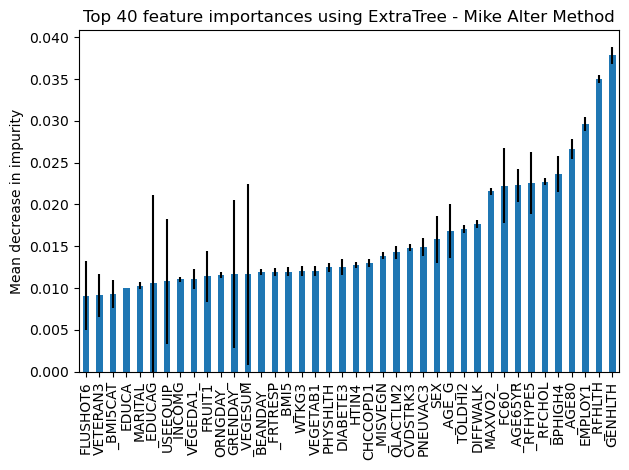

In [31]:
# plot top 40 most important features
forest_importances = pd.Series(importances, index=X_transform.columns).sort_values()[
    -40:
]
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std[-40:], ax=ax)
ax.set_title("Top 40 feature importances using ExtraTree - Mike Alter Method")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('features_mike.png')

In [32]:
# MIKES
all_importances = pd.Series(importances, index=X_transform.columns).sort_values()

pd.DataFrame(all_importances).reset_index().rename(
    {"index": "Feature", 0: "Importance"}, axis=1
).to_csv("forest_importances_mike_alter_method.csv", index=False)

### Compare Feature selection methodologies
- Here I compare feature selecction original (by Madeline) with feature Selection Mike Alternative method
- Mike Alternative method, like Madelines', drop the following:
    - all rows where  '_MICHD' is missing
    - all columns with 30% or more missingness
- Then, before balancing Dataset, unlike Madelines', Mike
    - drop all rows with missing values where _MICHD = 0
    - This is made to ensure than downsampling _MICHD = 0 (no heart disease) is made from a subset of rows with no empty values (each row is full and void of NaN values).

Below, I load forest_importance.csv authored by Madeline (from shared google drive)
- in your case, point to wherever such file is located

In [33]:
features_original = pd.read_csv('forest_importances_madeline.csv').sort_values(by='Importance', ascending=False)
features_original['Importance_original'] = (features_original['Importance']*100).round(3)
features_original.drop(['Importance'], axis=1, inplace= True)
features_original.shape

(109, 2)

In [34]:
all_importances = pd.Series(importances, index=X_transform.columns).sort_values()

features_alternative = pd.DataFrame(all_importances).reset_index().rename({"index": "Feature", 0: "Importance"}, axis=1).\
                                                                             sort_values(by='Importance', ascending=False)

features_alternative['Importance_alter'] = (features_alternative['Importance']*100).round(3)
features_alternative.drop(['Importance'], axis=1, inplace= True)
features_alternative.shape

(109, 2)

In [35]:
# Merge DataFrames with outer join
merged_df = pd.merge(features_alternative, features_original, on='Feature', how='outer')

# Fill NaN values with 0 (indicating no change)
merged_df.fillna(0, inplace=True)

# Calculate Changes
merged_df['Ranking_Change'] = merged_df['Importance_alter'] - merged_df['Importance_original']

# Display the merged DataFrame with changes
merged_df.sort_values(by='Importance_alter', ascending=False).head()

,Feature,Importance_alter,Importance_original,Ranking_Change
0,GENHLTH,3.787,3.409,0.378
1,_RFHLTH,3.503,2.889,0.614
2,EMPLOY1,2.960,3.140,-0.180
3,_AGE80,2.667,3.214,-0.547
4,BPHIGH4,2.361,2.838,-0.477


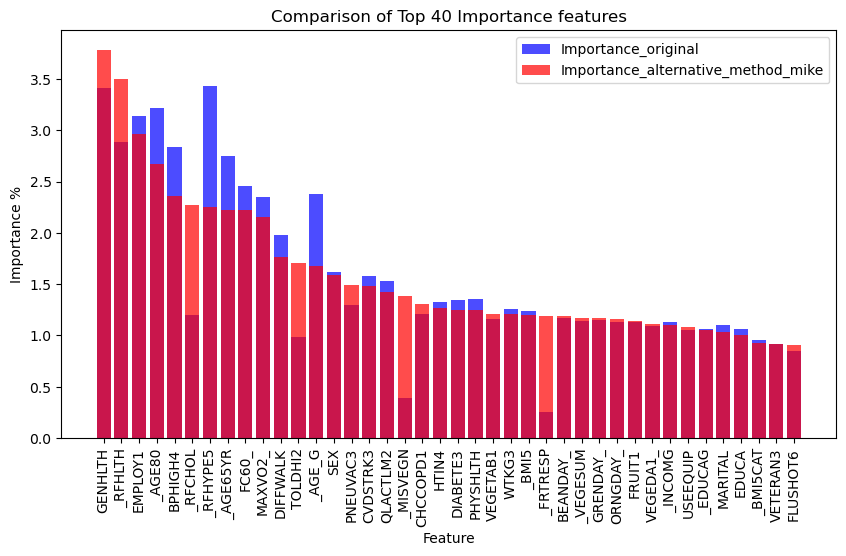

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# 
df = merged_df[:40]

# Plot bars for Importance_original
plt.bar(df['Feature'], df['Importance_original'], color='b', alpha=0.7, label='Importance_original')

# Plot bars for importance_alter
plt.bar(df['Feature'], df['Importance_alter'], color='r', alpha=0.7, label='Importance_alternative_method_mike')

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Importance %')
plt.title('Comparison of Top 40 Importance features')
plt.legend()
# Rotate x-axis labels to 90 degrees
plt.xticks(rotation=90)
# Adjust the bottom margin to leave space for x-axis labels
plt.subplots_adjust(bottom=0.2)

plt.savefig('features_comparison.png')

# Show the plot
plt.show()


### Generating Datasets with Mike Alternative Method of choosing Feature Importance

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [38]:
all_importances = pd.Series(importances, index=X_transform.columns).sort_values()

In [39]:
full_pipeline.fit(X_train)
# Transform the training data and convert it back to a DataFrame with column names
X_train = pd.DataFrame(
    full_pipeline.transform(X_train),
    columns=continuous
    + full_pipeline.named_transformers_["cat"]
    .get_feature_names_out(categorical)
    .tolist(),
)
X_test = pd.DataFrame(
    full_pipeline.transform(X_test),
    columns=continuous
    + full_pipeline.named_transformers_["cat"]
    .get_feature_names_out(categorical)
    .tolist(),
)

Saving datasets

In [ ]:
X_train.to_csv("datasets/mike_training_set_all_features_no_onehot_scaling.csv", index=False)
X_test.to_csv("datasets/mike_test_set_all_features_no_onehot_scaling.csv", index=False)
y_train.to_csv("datasets/mike_training_set_labels.csv", index=False)
y_test.to_csv("datasets/mike_test_set_labels.csv", index=False)